In [9]:
import sys
sys.path.append( '../utilities' )
from data_engine import DataEngine
from backtesting import Backtesting
import pandas as pd
import ta
import ccxt
import pandas_ta as pda

In [10]:
# pairList = pairJson['hitbtc2018']
pair = 'BTC/USDT'
timeframe = '1h'
startDate = '2017-01-01T00:00:00'

dataEngine = DataEngine(session=ccxt.binance(), path_to_data='./database/')

df = dataEngine.get_historical_from_db(pair, timeframe, startDate)

Successfully load 39409 candles for BTCUSDT


In [11]:
# -- Indicator variable --
trixLength = 9
trixSignal = 21
stochWindow = 14

# -- Drop all columns we do not need --
df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)

# -- Indicators, you can edit every value --
df['TRIX'] = ta.trend.ema_indicator(ta.trend.ema_indicator(ta.trend.ema_indicator(close=df['close'], window=trixLength), window=trixLength), window=trixLength)
df['TRIX_PCT'] = df["TRIX"].pct_change()*100
df['TRIX_SIGNAL'] = ta.trend.sma_indicator(df['TRIX_PCT'], trixSignal)
df['TRIX_HISTO'] = df['TRIX_PCT'] - df['TRIX_SIGNAL']
df['STOCH_RSI'] = ta.momentum.stochrsi(close=df['close'], window=stochWindow, smooth1=3, smooth2=3)

print("Indicators loaded 100%")
df

Indicators loaded 100%


,open,high,low,close,volume,TRIX,TRIX_PCT,TRIX_SIGNAL,TRIX_HISTO,STOCH_RSI
timestamp,,,,,,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,NaN,NaN,NaN,NaN,NaN
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,NaN,NaN,NaN,NaN,NaN
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,NaN,NaN,NaN,NaN,NaN
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,NaN,NaN,NaN,NaN,NaN
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-02-19 06:00:00,40237.76,40444.32,40208.67,40370.01,713.364020,40229.776400,-0.036997,-0.122127,0.085130,1.000000
2022-02-19 07:00:00,40370.01,40407.31,40241.86,40263.71,503.584900,40219.624524,-0.025235,-0.114876,0.089641,0.795762
2022-02-19 08:00:00,40263.70,40301.11,39933.83,39976.14,840.666240,40211.006048,-0.021429,-0.108023,0.086594,0.326185


In [12]:
# -- Intern parameter --
dfTest = df['2017-01-01':]
#ndfTest = df[:]
startingBalance = 1000
makerFee = 0.0002
takerFee = 0.0007

# -- Rules --
StopLossActivation = False
takeProfitActivation = False
timeLimitActivation = False
showLog = False
waitNextSignal = False

# -- Hyper parameters --
stochOverBought = 0.82
stochOverSold = 0.2
SlPct = 0.02
TpPct = 0.02
timeLimit = 17


# -- Trade Functions --
# -- Condition to BUY market --

def buyCondition(row, previousRow):
    if (
        row['TRIX_HISTO'] >= 0
        and row['STOCH_RSI'] < stochOverBought
    ):
        return True
    else:
        return False

# -- Condition to SELL market --


def sellCondition(row, previousRow):
    if (
        row['TRIX_HISTO'] < 0
        and row['STOCH_RSI'] > stochOverSold
    ):
        return True
    else:
        return False


# -- Value initialisation --
usd = startingBalance
wallet = startingBalance
coin = 0
lastAth = 0
previousRow = dfTest.iloc[0]
stopLoss = 0
takeProfit = 500000
currentTimeOpen = 0
timeSince = 0

# -- Definition of dfTrades, that will be the dataset to do your trades analyses --
dfTrades = None
dfTrades = pd.DataFrame(columns=['date', 'position', 'reason',
                                 'price', 'frais', 'fiat', 'coins', 'wallet', 'timeSince'])

# -- Iteration on all your price dataset (df) --
for index, row in dfTest.iterrows():
    timeSince += 1
    if currentTimeOpen > 0:
        currentTimeOpen += 1
    # -- Buy market order --
    if buyCondition(row, previousRow) and usd > 0:
        # -- You can define here at what price you buy --
        buyPrice = row['close']
        fee = takerFee * usd
        usd = usd - fee
        coin = usd / buyPrice
        usd = 0
        wallet = coin * row['close']

        if showLog:
            print("Buy COIN at", buyPrice, '$ the', index)

        # -- Add the trade to dfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Buy",
            'reason': 'Buy Market Order',
            'price': buyPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0
    # -- Sell Market Order --
    elif sellCondition(row, previousRow):
        if coin > 0:
            # -- You can define here at what price you buy --
            sellPrice = row['close']
            usd = coin * sellPrice
            fee = takerFee * usd
            usd = usd - fee
            coin = 0
            wallet = usd

            # -- Add the trade to DfTrades to analyse it later --
            myrow = {
                'date': index,
                'position': "Sell",
                'reason': 'Sell Market Order',
                'price': sellPrice,
                'frais': fee,
                'fiat': usd,
                'coins': coin,
                'wallet': wallet,
                'timeSince': timeSince
            }
            dfTrades = dfTrades.append(myrow, ignore_index=True)
            timeSince = 0
    previousRow = row

print("Final wallet", wallet)
print(dfTrades)

Final wallet 52509.0281809891
                    date position             reason     price      frais  \
0    2017-08-19 13:00:00      Buy   Buy Market Order   4039.84   0.700000   
1    2017-08-20 15:00:00     Sell  Sell Market Order   4125.00   0.714256   
2    2017-08-21 23:00:00      Buy   Buy Market Order   4016.00   0.713756   
3    2017-08-22 02:00:00     Sell  Sell Market Order   3849.98   0.683770   
4    2017-08-22 14:00:00      Buy   Buy Market Order   3849.00   0.683292   
...                  ...      ...                ...       ...        ...   
2038 2022-02-14 11:00:00      Buy   Buy Market Order  42117.87  35.350281   
2039 2022-02-15 22:00:00     Sell  Sell Market Order  44169.17  37.046024   
2040 2022-02-17 00:00:00      Buy   Buy Market Order  44060.74  37.020091   
2041 2022-02-17 06:00:00     Sell  Sell Market Order  43838.80  36.807833   
2042 2022-02-18 11:00:00      Buy   Buy Market Order  40178.94  36.782067   

              fiat     coins        wallet ti

In [13]:
BTobject = Backtesting()
newDf = BTobject.simple_spot_backtest_analys(dfTrades=dfTrades, dfTest=dfTest, pairSymbol=pair, timeframe=timeframe)

Pair Symbol : BTC/USDT | Timeframe : 1h
Period : [2017-08-17 04:00:00] -> [2022-02-19 10:00:00]
Starting balance : 999.3 $

----- General Informations -----
Final balance : 52509.03 $
Performance vs US Dollar : 5154.58 %
Buy and Hold Performence : 824.24 %
Performance vs Buy and Hold : 468.53 %
Best trade : +24.24 %, the 2019-10-26 21:00:00
Worst trade : -16.31 %, the 2021-12-04 08:00:00
Worst drawDown : - 62.35 %
Total fees :  44956.65 $

----- Trades Informations -----
Total trades on period : 1021
Number of positive trades : 506
Number of negative trades :  515
Trades win rate ratio : 49.56 %
Average trades performance : 0.53 %
Average positive trades : 2.94 %
Average negative trades : -1.83 %

----- Time Informations -----
Average time duration for a trade : 19.11 periods
Maximum time duration for a trade : 66 periods
Minimum time duration for a trade : 1 periods
Average time duration between two trades : 19.44 periods
Maximum time duration between two trades : 67 periods
Minimum t

----- 2017 Performances: 181.64% -----


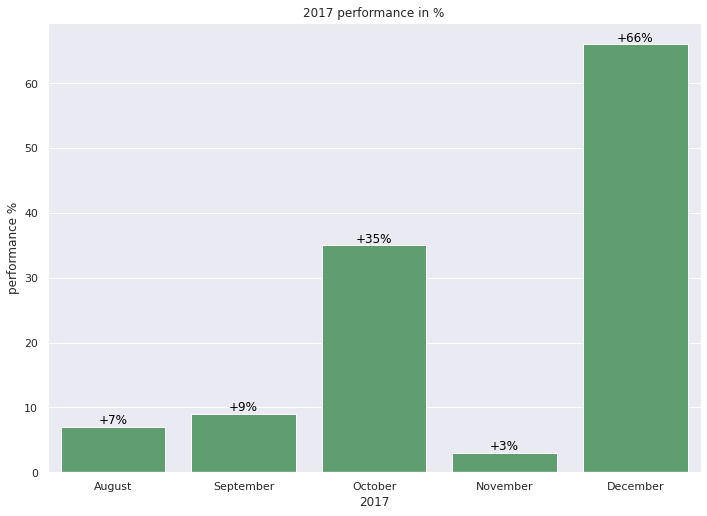

----- 2018 Performances: 122.44% -----


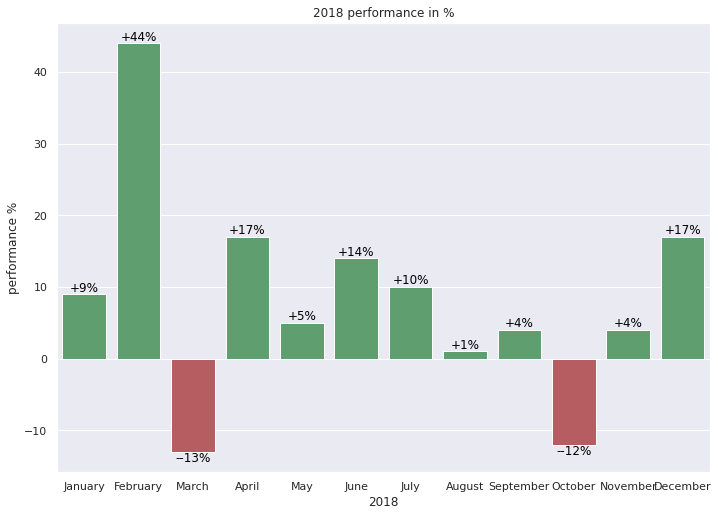

----- 2019 Performances: 73.89% -----


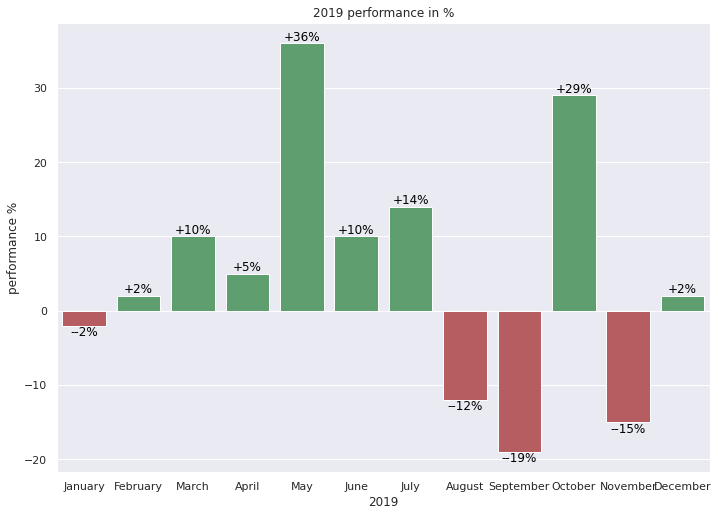

----- 2020 Performances: 415.07% -----


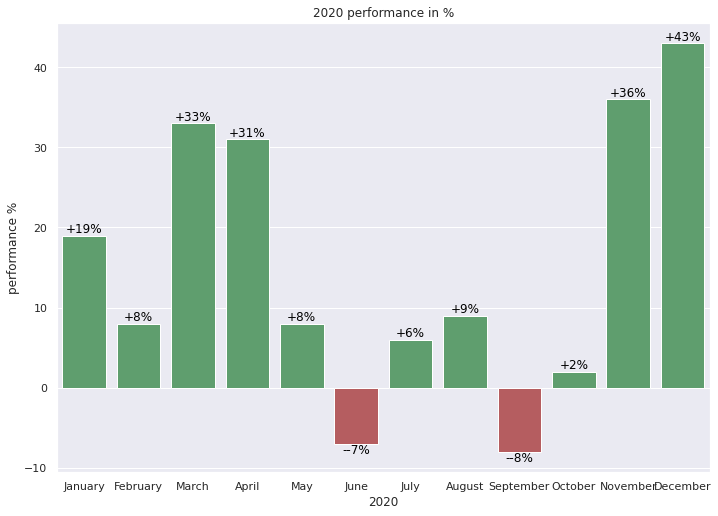

----- 2021 Performances: -1.1% -----


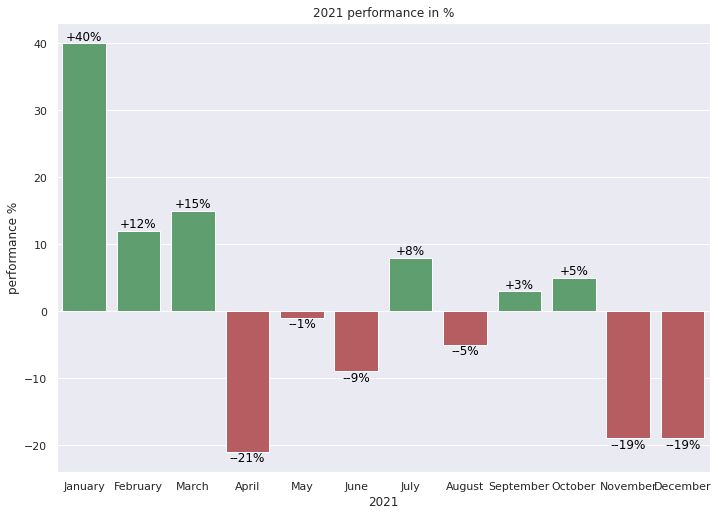

----- 2022 Performances: -11.44% -----


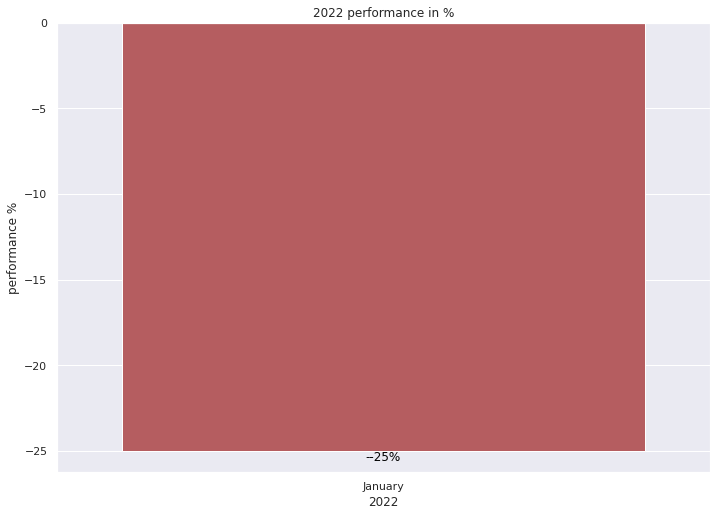

In [14]:
BTobject.plot_bar_by_month(dfTrades=dfTrades)


----- Plot -----


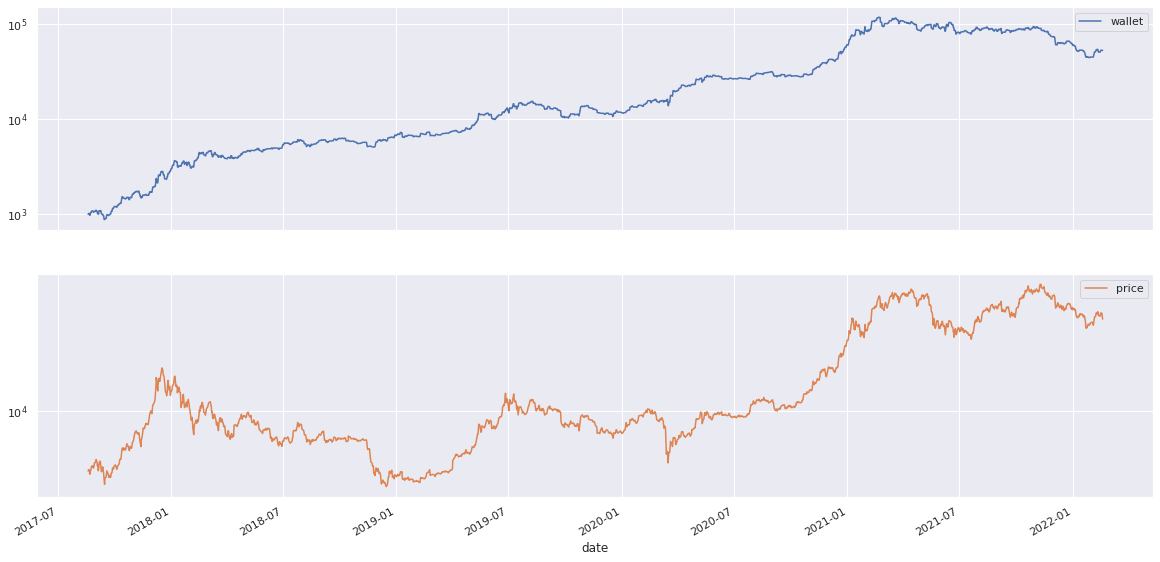

In [15]:
BTobject.plot_wallet_vs_price(dfTrades=dfTrades)